Experiment with PCA for visualization/Speed up model training and prediction without losing too much predictive power

In [1]:
%run Preprocessing.ipynb

Automatically created module for IPython interactive environment


In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor

In [3]:
X_train, y_train, X_test, y_test = preprocess()

/home/cfu288/anaconda3/envs/rdkit-env/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [4]:
n_components=200
X = X_train
pca = PCA(n_components=n_components)
X_r = pca.fit(X).transform(X)

X = X_test
X_r1 = pca.transform(X)

pd.DataFrame(X_r, columns=["PC{}".format(x) for x in range(1,n_components+1)]).head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC191,PC192,PC193,PC194,PC195,PC196,PC197,PC198,PC199,PC200
0,0.028378,-0.026520,0.292802,-0.111242,-0.209545,-0.075946,-0.200334,0.112061,0.034613,0.038201,...,0.005707,0.009261,0.000538,-0.013862,0.011824,0.004031,0.015849,0.007477,-0.005044,-0.002060
1,-0.066070,0.028518,0.191551,0.049345,-0.123992,0.103399,-0.048598,-0.021532,0.161290,0.146342,...,0.073344,0.031881,0.026946,-0.000668,0.036658,0.035941,-0.002661,0.092650,-0.062638,0.047169
2,0.804166,0.048277,-0.114207,-0.058066,-0.056170,0.023820,-0.025198,0.048915,0.004822,0.010301,...,0.012786,-0.006223,0.000497,-0.009987,0.002794,-0.023502,-0.007857,0.016442,-0.005300,-0.010007
3,-0.020718,-0.035594,0.327822,-0.140343,-0.248905,-0.088257,-0.268087,0.157591,0.041040,0.098089,...,-0.006248,-0.003664,-0.003556,-0.001422,0.007473,0.003822,0.009137,-0.000354,0.013056,-0.005115
4,0.720153,0.042213,-0.133070,-0.095101,-0.070298,0.026620,-0.009505,0.059033,0.035170,0.032821,...,-0.010537,0.013419,-0.013580,0.013827,0.008599,0.018277,0.007619,-0.012795,0.003434,-0.014067


In [5]:
# Percentage of variance explained for each components
print('explained variance ratio (first {} components): \n{}'.format(
    n_components,
    str(pca.explained_variance_ratio_)
    )
)

explained variance ratio (first 200 components): 
[0.05715731 0.04784566 0.03516078 0.02815847 0.02486844 0.0236141
 0.02030555 0.01967653 0.01939501 0.01753981 0.01576522 0.01455027
 0.01333859 0.01281451 0.01229297 0.01180809 0.01092908 0.0103066
 0.00975281 0.00898957 0.00889667 0.00856863 0.00811059 0.00791463
 0.0077264  0.0074961  0.00726094 0.00681713 0.00645731 0.00634959
 0.00625685 0.0059935  0.00576742 0.00567673 0.00550129 0.00547614
 0.00531106 0.0051768  0.00512524 0.00497307 0.00486694 0.0047226
 0.00462545 0.00460494 0.00444952 0.00440487 0.00431798 0.00426061
 0.00418586 0.00403121 0.00388624 0.00385804 0.00379386 0.00374971
 0.00358395 0.00349469 0.00345063 0.00341569 0.00340051 0.00334533
 0.00326469 0.00325714 0.00318684 0.00311498 0.0030979  0.00302906
 0.00302372 0.00297869 0.0029327  0.00285831 0.00284302 0.00282036
 0.00276136 0.00274661 0.00270033 0.00266628 0.00265114 0.00253929
 0.00252101 0.00248433 0.00246659 0.00244002 0.00243347 0.00239129
 0.00236563 0.0

In [6]:
tot = 0
for i, val in enumerate(pca.explained_variance_ratio_):
    if i == len(pca.explained_variance_ratio_)-1:
        print("Need More PC to reach 85%")
    elif tot >= .85:
        print("{} PC were needed to reach 85%".format(i))
        break
    else:
        tot+=val


191 PC were needed to reach 85%


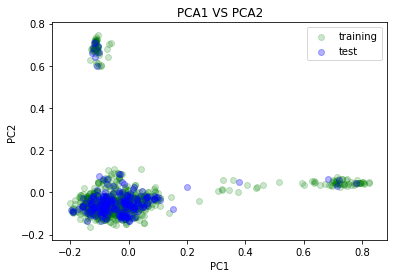

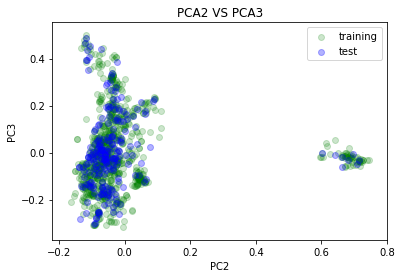

In [7]:
# Gime us an image that can help us visualize how similar each molecule is to each other, 
# as well as how similar the training set is to the test set
plt.figure()
lw = 1

plt.scatter(X_r[:, 0], X_r[:, 1], alpha=.2, lw=lw, color='green', label='training')
plt.scatter(X_r1[:, 0], X_r1[:, 1], alpha=.3, lw=lw, color='blue', label='test')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title('PCA1 VS PCA2')


plt.figure()
lw = 1

plt.scatter(X_r[:, 1], X_r[:, 2], alpha=.2, lw=lw, color='green', label='training')
plt.scatter(X_r1[:, 1], X_r1[:, 2], alpha=.3, lw=lw, color='blue', label='test')
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.xlabel("PC2")
plt.ylabel("PC3")
plt.title('PCA2 VS PCA3')

plt.show()

In [8]:
print("In the above image we are only vizualising {:.2f}% of all of the variance.".format(sum(pca.explained_variance_ratio_[:2])*100))

In the above image we are only vizualising 10.50% of all of the variance.


In [9]:
in_data = {'X_train':X_r, 'y_train':y_train, 'X_test':X_r1, 'y_test':y_test}

In [10]:
# Grid search
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'degree':[2,3,4], 'kernel': ['poly']},
  {'C': [1, 10, 100, 1000], 'gamma': [1 ,1e-1, 1e-2, 1e-3, 1e-4, 1e-5], 'kernel': ['rbf']},
 ]

clf = GridSearchCV(estimator=SVR(), param_grid=param_grid, cv=None, n_jobs=-1)
clf.fit(X_r, y_train)
print("best estimator: {}".format(clf.best_estimator_))

/home/cfu288/anaconda3/envs/rdkit-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


best estimator: SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


/home/cfu288/anaconda3/envs/rdkit-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)



SVM Regression

r^2: 0.786
RMSE: 0.779
MSE train: 0.166
MSE test: 0.607
So, in our model, 78.631% of the variability in Y can be explained using X. 
Our model predicted most of the lipophilicity values in the test set within 0.78 of the real value.


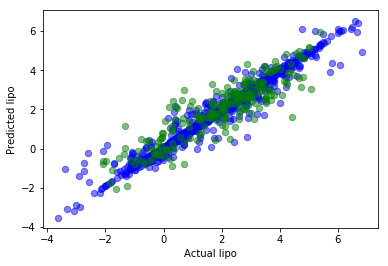

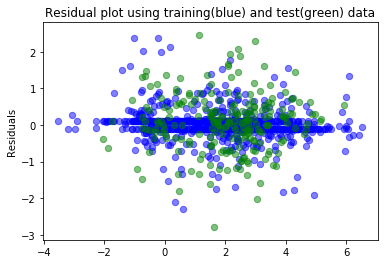

In [11]:
svm_model = clf.best_estimator_
model = test_model(svm_model, "SVM Regression", in_data)

In [12]:
rfc = RandomForestRegressor(n_jobs=-1) 

param_grid = { 
    'n_estimators': [10, 100, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1,3,5],
}

CV_rf = GridSearchCV(estimator=rfc, param_grid=param_grid)
CV_rf.fit(X_r, y_train)

/home/cfu288/anaconda3/envs/rdkit-env/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/home/cfu288/anaconda3/envs/rdkit-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [10, 100, 500, 1000], 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_leaf': [1, 3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)


RandomForestRegressor Regression

r^2: 0.621
RMSE: 1.037
MSE train: 0.182
MSE test: 1.076
So, in our model, 62.113% of the variability in Y can be explained using X. 
Our model predicted most of the lipophilicity values in the test set within 1.04 of the real value.


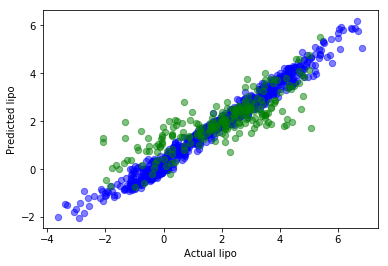

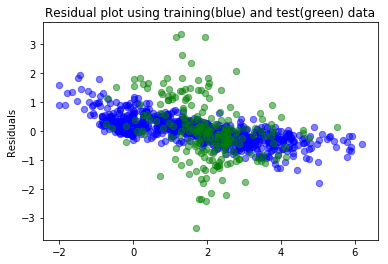

In [13]:
rf_model = CV_rf.best_estimator_
model = test_model(rf_model, "RandomForestRegressor Regression", in_data)